**Restaurant Reviews Sentiment Analysics**


In [47]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from bs4 import BeautifulSoup
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle
warnings.filterwarnings("ignore")

Data Loading


In [48]:
df = pd.read_csv("a1_RestaurantReviews_HistoricDump.tsv", sep="\t")

In [49]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [50]:
df.shape

(900, 2)

In [51]:
df["Liked"].value_counts()

Liked
1    496
0    404
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x194f28c4f50>,
 [Text(-0.17586927573571567, 1.0858498965566996, '1'),
  Text(0.17586927573571554, -1.0858498965566996, '0')],
 [Text(-0.0959286958558449, 0.5922817617581997, '55.1%'),
  Text(0.09592869585584482, -0.5922817617581997, '44.9%')])

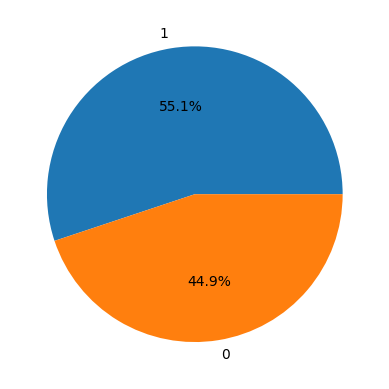

In [52]:
plt.pie(
    x=df["Liked"].value_counts().values,
    labels=df["Liked"].value_counts().index,
    autopct="%1.1f%%",
)

In [53]:
df.isnull().sum()

Review    0
Liked     0
dtype: int64

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  900 non-null    object
 1   Liked   900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [55]:
def word_cloud(dataframe, review):
    temp_df = dataframe["Review"][dataframe["Liked"] == review]
    text_data = " ".join(temp_df)
    wordcloud = WordCloud(
        background_color="white", colormap="coolwarm", max_words=10
    ).generate(text_data)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

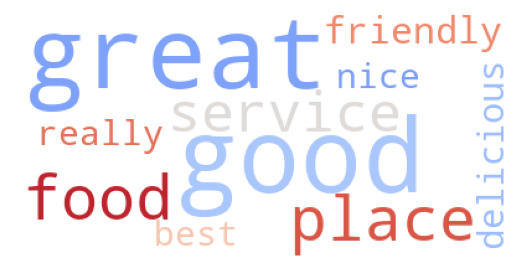

In [56]:
word_cloud(df, 1)

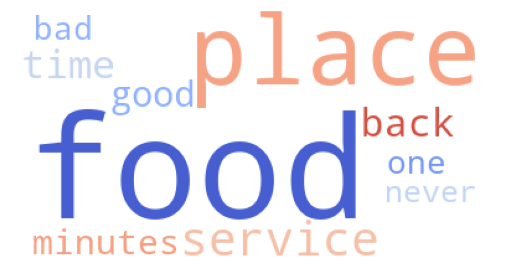

In [57]:
word_cloud(df, 0)

Text Cleaning

i.e (Droping SP and No. Char, Conerting into Lower case, Droping Stopword, and apply Stemming.)
after apply all above step the O/P should be ['text1','text2',....] in this Format...


In [58]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

In [59]:
def text_lower(text):
    return text.lower()

In [60]:
def remove_punctuation(text):
    translator = str.maketrans(" ", " ", string.punctuation)
    return text.translate(translator)

In [61]:
def remove_number(text):
    return re.sub(r"\d", " ", text)

In [62]:
def remove_whitespace(text):
    return " ".join(text.split())

In [63]:
def remove_contractions(text):
    return contractions.fix(text)

In [64]:
def remove_HTML_tag(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [65]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return " ".join(words)

In [66]:
def stem_words(text):
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

In [67]:
def clean_text(dataframe, column_name):
    dataframe_copy=dataframe.copy()
    print("\n=== Cleaning Process ===")

    print("\n⬇️ Removing HTML Tags ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(remove_HTML_tag)

    print("\n⬇️ Lowercasing Text ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(text_lower)

    print("\n⬇️ Removing Punctuation ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(remove_punctuation)

    print("\n⬇️ Removing Numbers ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(remove_number)

    print("\n⬇️ Removing Whitespace ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(remove_whitespace)

    print("\n⬇️ Expanding Contractions ⬇️")
    dataframe[column_name] = dataframe[column_name].apply(remove_contractions)

    print("\n⬇️ Removing Stopwords ⬇️")
    dataframe[column_name] = dataframe[column_name].apply(remove_stopwords)

    print("\n⬇️ Stemming Words ⬇️")
    dataframe_copy[column_name] = dataframe_copy[column_name].apply(stem_words)

    print("\n=== Cleaning Completed ===\n")
    return dataframe_copy

In [68]:
clean_df = clean_text(df, "Review")


=== Cleaning Process ===

⬇️ Removing HTML Tags ⬇️

⬇️ Lowercasing Text ⬇️

⬇️ Removing Punctuation ⬇️

⬇️ Removing Numbers ⬇️

⬇️ Removing Whitespace ⬇️

⬇️ Expanding Contractions ⬇️

⬇️ Removing Stopwords ⬇️

⬇️ Stemming Words ⬇️

=== Cleaning Completed ===



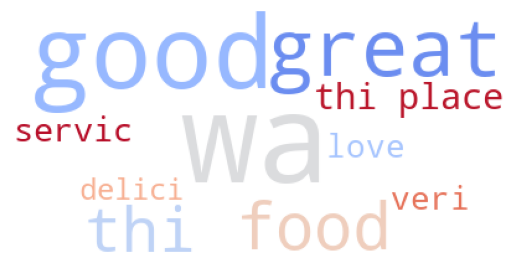

In [69]:
word_cloud(clean_df, 1)

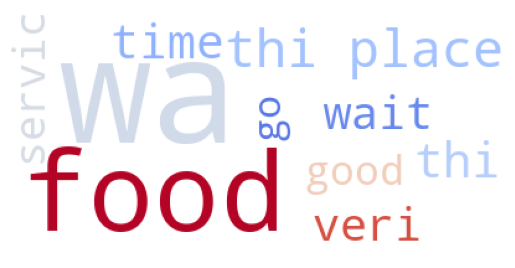

In [70]:
word_cloud(clean_df, 0)

In [71]:
CORPUS = np.array(clean_df["Review"])
type(CORPUS)

numpy.ndarray

In [72]:
len(CORPUS)

900

In [73]:
CORPUS[0]

'wow love thi place'

In [74]:
y = df["Liked"]

Train Test Split


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    CORPUS, y, test_size=0.2, random_state=42
)

In [76]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Naive Bayes (MultinomialNB)", MultinomialNB()),
    ("Support Vector Machines (SVM)", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting Machines (XGBoost)", XGBClassifier()),
    ("K-Nearest Neighbors (KNN)", KNeighborsClassifier()),
    ("Decision Trees", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Extra Trees", ExtraTreesClassifier()),
    ("Ensemble Methods (AdaBoost)", AdaBoostClassifier()),
    (
        "Ensemble Methods (Voting Classifier)",
        VotingClassifier(
            estimators=[
                ("lr", LogisticRegression()),
                ("svm", SVC()),
                ("rf", RandomForestClassifier()),
            ]
        ),
    ),
    (
        "Ensemble Methods (Bagging)",
        BaggingClassifier(base_estimator=DecisionTreeClassifier()),
    ),
    ("Ensemble Methods (Gradient Boosting)", GradientBoostingClassifier()),
]

In [77]:
def evaluate_classification_model(model_name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[("vectorizer", CountVectorizer()), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    # Print classification report
    print("Training Report")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_train, y_train_pred))

    # Print confusion matrix
    print(f"{model_name} Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))
    print("Test Report")
    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Print confusion matrix
    print(f"{model_name} Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

In [78]:
for model_name, model in models:
    evaluate_classification_model(model_name, model, X_train, y_train, X_test, y_test)

Training Report
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       322
           1       0.99      0.98      0.99       398

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720

Logistic Regression Confusion Matrix:
[[320   2]
 [  8 390]]
Test Report
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73        82
           1       0.77      0.82      0.79        98

    accuracy                           0.77       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

Logistic Regression Confusion Matrix:
[[58 24]
 [18 80]]
Training Report
Naive Bayes (MultinomialNB) Classification Report:
              precision    recall  f1-score   s

Based on this analysis, the top-performing models from best to worst are:

- Random Forest
- Support Vector Machines (SVM)
- Ensemble Methods (Voting Classifier)
- Ensemble Methods (Bagging)
- Ensemble Methods (Gradient Boosting)
- Naive Bayes (MultinomialNB)
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Decision Trees
- Extra Trees

So, i choose `Random Forest` for further step.

In [79]:
pipeline_rf=Pipeline(steps=[("vectorizer", CountVectorizer()), ("model", RandomForestClassifier())])

In [80]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('model', RandomForestClassifier())])

In [81]:
y_train_pred = pipeline_rf.predict(X_train)
y_test_pred = pipeline_rf.predict(X_test)
    # Print classification report
print("Training Report")
print(f"Random Forest Classification Report:")
print(classification_report(y_train, y_train_pred))

    # Print confusion matrix
print(f"Random Forest Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Test Report")
    # Print classification report
print(f"Random Forest Classification Report:")
print(classification_report(y_test, y_test_pred))

    # Print confusion matrix
print(f"Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Training Report
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       398

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

Random Forest Confusion Matrix:
[[322   0]
 [  0 398]]
Test Report
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        82
           1       0.74      0.85      0.79        98

    accuracy                           0.76       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.76      0.76      0.75       180

Random Forest Confusion Matrix:
[[53 29]
 [15 83]]


In [82]:
def prediction(dataframe,column):
    clean_df = clean_text(dataframe, column)
    CORPUS = np.array(clean_df["Review"])
    pred = pipeline_rf.predict(CORPUS)
    
    result_df = pd.DataFrame({'Review': clean_df[column], 'Prediction': pred})
    
    return result_df
    
    

In [83]:
positive_restaurant_reviews = [
    "I had a delightful dining experience at this restaurant. The food was exquisite, the service was impeccable, and the ambiance was charming. I will definitely be coming back!",
    "The chef at this restaurant is truly talented. Every dish was a culinary masterpiece, and the presentation was top-notch. A fantastic place for food enthusiasts.",
    "The staff here is exceptional. They are attentive, friendly, and always make you feel welcome. It's a pleasure dining at this establishment.",
    "I celebrated a special occasion at this restaurant, and it was perfect. The attention to detail, from the menu to the decor, made the evening memorable.",
    "This restaurant exceeded my expectations. The menu offers a diverse range of dishes, and each one I tried was delicious. A must-visit for food lovers!",
]

In [84]:
negative_restaurant_reviews = [
    "My experience at this restaurant was disappointing. The service was slow, the food was mediocre, and the overall atmosphere lacked warmth.",
    "I had high hopes for this place, but it fell short. The portions were small, and the flavors were underwhelming. I won't be returning.",
    "The staff seemed overwhelmed and unorganized. It took ages to get our orders, and the quality of the food didn't justify the wait.",
    "I had a bad encounter with the waitstaff. They were rude and inattentive, making the dining experience unpleasant.",
    "Unfortunately, the hygiene standards at this restaurant were not up to par. The cleanliness of the facilities left much to be desired, impacting the overall experience.",
]

In [85]:
df_positive_reviews = pd.DataFrame(positive_restaurant_reviews, columns=['Review'])
df_negative_reviews = pd.DataFrame(negative_restaurant_reviews, columns=['Review'])

In [86]:
pre=prediction(df_positive_reviews,'Review')


=== Cleaning Process ===

⬇️ Removing HTML Tags ⬇️

⬇️ Lowercasing Text ⬇️

⬇️ Removing Punctuation ⬇️

⬇️ Removing Numbers ⬇️

⬇️ Removing Whitespace ⬇️

⬇️ Expanding Contractions ⬇️

⬇️ Removing Stopwords ⬇️

⬇️ Stemming Words ⬇️

=== Cleaning Completed ===



In [87]:
df_positive_reviews['Prediction']=pre['Prediction']

In [88]:
df_positive_reviews

,Review,Prediction
0,delightful dining experience restaurant. food ...,1
1,chef restaurant truly talented. Every dish cul...,1
2,"staff exceptional. attentive, friendly, always...",1
3,"celebrated special occasion restaurant, perfec...",1
4,restaurant exceeded expectations. menu offers ...,1


In [89]:
pre=prediction(df_negative_reviews,'Review')


=== Cleaning Process ===

⬇️ Removing HTML Tags ⬇️

⬇️ Lowercasing Text ⬇️

⬇️ Removing Punctuation ⬇️

⬇️ Removing Numbers ⬇️

⬇️ Removing Whitespace ⬇️

⬇️ Expanding Contractions ⬇️

⬇️ Removing Stopwords ⬇️

⬇️ Stemming Words ⬇️

=== Cleaning Completed ===



In [90]:
df_negative_reviews['Prediction']=pre['Prediction']

In [91]:
df_negative_reviews

,Review,Prediction
0,experience restaurant disappointing. service s...,0
1,"high hopes place, fell short. portions small, ...",0
2,staff seemed overwhelmed unorganized. took age...,0
3,"bad encounter waitstaff. rude inattentive, mak...",0
4,"Unfortunately, hygiene standards restaurant pa...",0


In [92]:
df_test=pd.read_csv('a2_RestaurantReviews_FreshDump.tsv',sep='\t')

In [93]:
df_test.head()

,Review
0,Spend your money elsewhere.
1,Their regular toasted bread was equally satisf...
2,The Buffet at Bellagio was far from what I ant...
3,"And the drinks are WEAK, people!"
4,-My order was not correct.


In [94]:
pre=prediction(df_test,'Review')


=== Cleaning Process ===

⬇️ Removing HTML Tags ⬇️

⬇️ Lowercasing Text ⬇️

⬇️ Removing Punctuation ⬇️

⬇️ Removing Numbers ⬇️

⬇️ Removing Whitespace ⬇️

⬇️ Expanding Contractions ⬇️

⬇️ Removing Stopwords ⬇️

⬇️ Stemming Words ⬇️

=== Cleaning Completed ===



In [95]:
df_test['Prediction']=pre['Prediction']

In [96]:
df_test.head()

,Review,Prediction
0,Spend money elsewhere.,0
1,regular toasted bread equally satisfying occas...,1
2,Buffet Bellagio far anticipated.,1
3,"drinks WEAK, people!",1
4,-My order correct.,0


In [97]:
with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline_rf, file)